In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
from datetime import datetime
import pyproj

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import torch

from scipy.interpolate import griddata

import cdsapi
import xarray as xr
from urllib.request import urlopen

from urllib.request import urlretrieve

import pickle

%reload_ext autoreload
%autoreload 2

from functions import *
from models import *
# from torch_model import *

In [3]:
import dgl.data
dataset = dgl.data.GINDataset('MUTAG', False)

C:\Users\yoko2261\.dgl\GINDataset.zip: 100%|██████████████████████████████████████| 33.4M/33.4M [00:02<00:00, 16.4MB/s]


Extracting file to C:\Users\yoko2261\.dgl\GINDataset


In [11]:
dataset[:][1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
laps = 4

n_samples, var_ip, row, col = np.shape(inputs)
_, var_op, _, _ = np.shape(outputs)

inputs[np.isnan(inputs)] = 0
# outputs[np.isnan(outputs)] = 0

first = True
for n in tqdm(range(0, n_samples-laps)):
    # sic = inputs[n+laps, 2, :, :]
    # valid = np.where((sic > 0.8) & (outputs[n+laps, 0] > 0) & (outputs[n+laps, 0] <= 1) & (mask))

    # n_valid = valid[0].shape[0]

    ann_input0 = np.zeros([1, var_ip * laps, row, col])
    ann_output0 = np.zeros([1, var_op, row, col])
    
    for v in range(0, var_ip):
        for i in range(0, laps):
            ann_input0[0, v*laps+i] = normalize_input(inputs[n+i, v], v)
    for v in range(0, var_op):
        ann_output0[0, v] = outputs[n+laps, v]

    if first:
        ann_input = ann_input0
        ann_output = ann_output0
        first = False
    else:
        ann_input = np.concatenate((ann_input, ann_input0), axis = 0)
        ann_output = np.concatenate((ann_output, ann_output0), axis = 0)

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.80it/s]


In [ ]:
c = 1
laps = 4
sector = "Ross"
files = glob.glob(f'D:\\IS2_topo_DL\\data\\Data_{sector}_*.pkl')
xx, yy, inputs, outputs = read_grid_input(files, c)

In [ ]:
ann_input, ann_output = make_cnn_input(inputs, outputs, laps)

train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.4, random_state=42)

# train_input = torch.tensor(train_input, dtype=torch.float32)
# train_output = torch.tensor(train_output, dtype=torch.float32)
# val_input = torch.tensor(val_input, dtype=torch.float32)
# val_output = torch.tensor(val_output, dtype=torch.float32)

# train_dataset = TensorDataset(train_input, train_output)
# train_loader = DataLoader(train_dataset, batch_size=batch_size)
# val_dataset = TensorDataset(val_input, val_output)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# n_samples, in_channels = train_input.size()
# _, out_channels = train_output.size()
# print(f"##### TRAINING DATA IS PREPARED (Samples: {n_samples}; model: {args.model}) #####")

# features, hidden_layers = 128, 2
# net = MLP(in_channels, out_channels, features, hidden_layers)
# model_name = f"torch_{sector}_c{c}_lap{laps}_{args.model}_h{hidden_layers}_f{features}"
# print(model_name)

In [ ]:
ann_input, ann_output = make_mlp_input(inputs[:,:9], outputs[:,1:2], laps = laps)

In [ ]:
ann_

In [ ]:
train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.6, random_state=42)

In [165]:
train_input.shape, train_output.shape, val_input.shape, val_output.shape

((19241, 36), (19241, 1), (28862, 36), (28862, 1))

In [144]:
n_samples = ann_input.shape[0]
torch.randint(0, n_samples, (int(n_samples),), generator=torch.Generator().manual_seed(42))

tensor([45704, 33665, 46001,  4086, 47870, 31433, 19332, 21047, 33313, 44429])

In [136]:
a1 = random_split(a, [0.5, 0.5], generator=torch.Generator().manual_seed(42))
b1 = random_split(b, [0.5, 0.5], generator=torch.Generator().manual_seed(42))

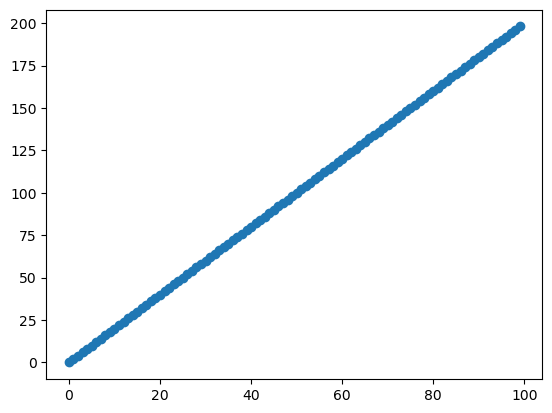

In [137]:
plt.scatter(a1, b1)

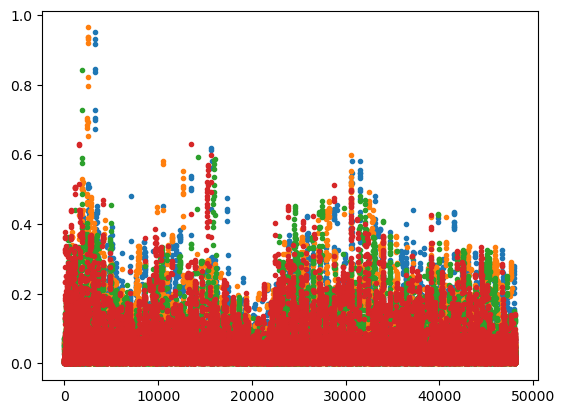

In [159]:
c = 8
plt.plot(ann_input[:, c*laps:(c+1)*laps], '.')

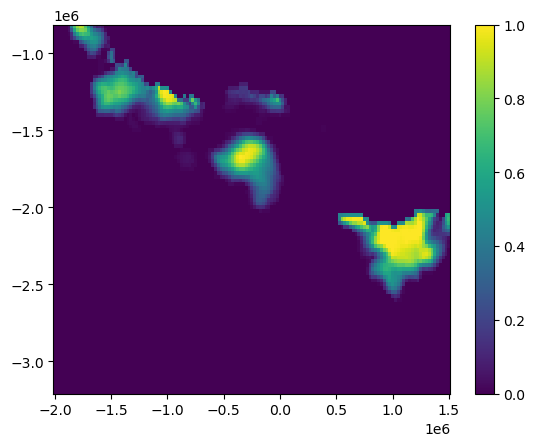

In [24]:
i = 60
c = 2
plt.pcolormesh(xx, yy, inputs[i, c])
plt.colorbar()

In [47]:
ds = retrieve_hourly_ERA5(year, ['04'], ['10', '11'])

2024-07-23 10:11:15,144 INFO Welcome to the CDS
2024-07-23 10:11:15,144 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-23 10:11:15,757 INFO Request is completed


In [67]:
months = ['04']
days = ['10', '11']
c = cdsapi.Client(quiet=True, debug=False)
# dataset to read
dataset = 'reanalysis-era5-single-levels'
# flag to download data
# download_flag = False
variables = [
    '10m_u_component_of_wind', '10m_v_component_of_wind', 'instantaneous_10m_wind_gust',
    '2m_temperature', 'sea_ice_cover', 'surface_pressure'
]

params = {
    'format': 'netcdf',
    'product_type': 'reanalysis',
    'variable': variables,
    'year':[str(year)],
    'month': months,
    'day': days,
    'time': ['12:00'],
    'grid': [1, 0.5],
    'area': [-50, -180, -90, 180]
    }

# retrieves the path to the file
fl = c.retrieve(dataset, params)

2024-07-23 10:38:13,641 INFO Welcome to the CDS
2024-07-23 10:38:13,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-23 10:38:13,949 INFO Request is completed


In [50]:
import inspect

In [53]:
inspect.getargspec(c.retrieve)

ArgSpec(args=['self', 'name', 'request', 'target'], varargs=None, keywords=None, defaults=(None,))

In [4]:
filepath = "D:\\IS2_topo_DL"
region = "Ross"
year = 2019

##### Read data ##############################
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass

ncname = filepath + f'\\Ridges_density_{region}_{year}.nc'
ds = xr.open_dataset(ncname)

with netCDF4.Dataset(ncname, 'r') as nc:
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)

    times = nc.variables['time']
    times = num2date(times[:], units = times.units)

    hours = np.array(nc.variables['time']).astype(float)
    time_era = []

    for i in range(0, len(hours)):
        time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))

date1, date2 = [], []
for m in range(1, 13):
    date1.append(dt.datetime(year,m,1))
    if m == 12:
        date2.append(dt.datetime(year+1,1,1))
    else:
        date2.append(dt.datetime(year,m+1,1))

fields = ['fb_mode']
output = np.zeros([len(fields), len(date1), xx.shape[0], xx.shape[1]])

for k, field1 in enumerate(fields):
    for i in range(0, len(date1)):                

        tidx = np.where((times >= date1[i]) & (times < date2[i]))[0]
        fb_count = np.nansum(np.array(ds.variables["fb_count"][tidx, :, :]), axis = 0)
        valid_count = (fb_count > 500)
        
        if np.sum(tidx) > 0:
            array = np.array(ds.variables[field1][tidx, :, :])
            # array = np.transpose(np.array(ds.variables[field1][tidx, :, :]), axes = (0, 2, 1))
            data1 = np.nanmedian(array, axis = 0)
            data1[~valid_count] = np.nan

        output[k, i] = np.transpose(np.nanmean(array, axis = 0))
        

In [7]:
output.shape

(1, 12, 96, 141)

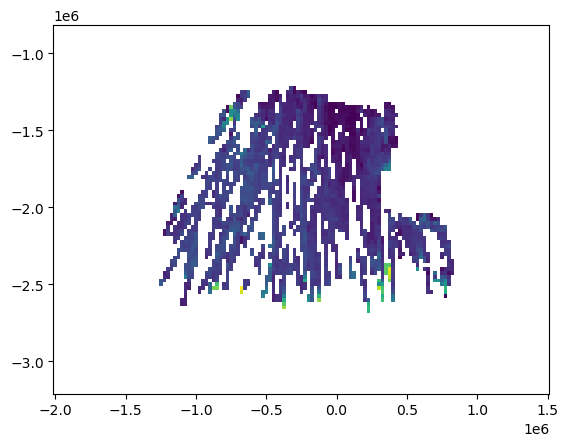

In [9]:
plt.pcolormesh(xx, yy, output[0, 4])

In [8]:
xx.shape

(96, 141)